<a href="https://colab.research.google.com/github/sleptonium/demos/blob/main/TRL_for_agent_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

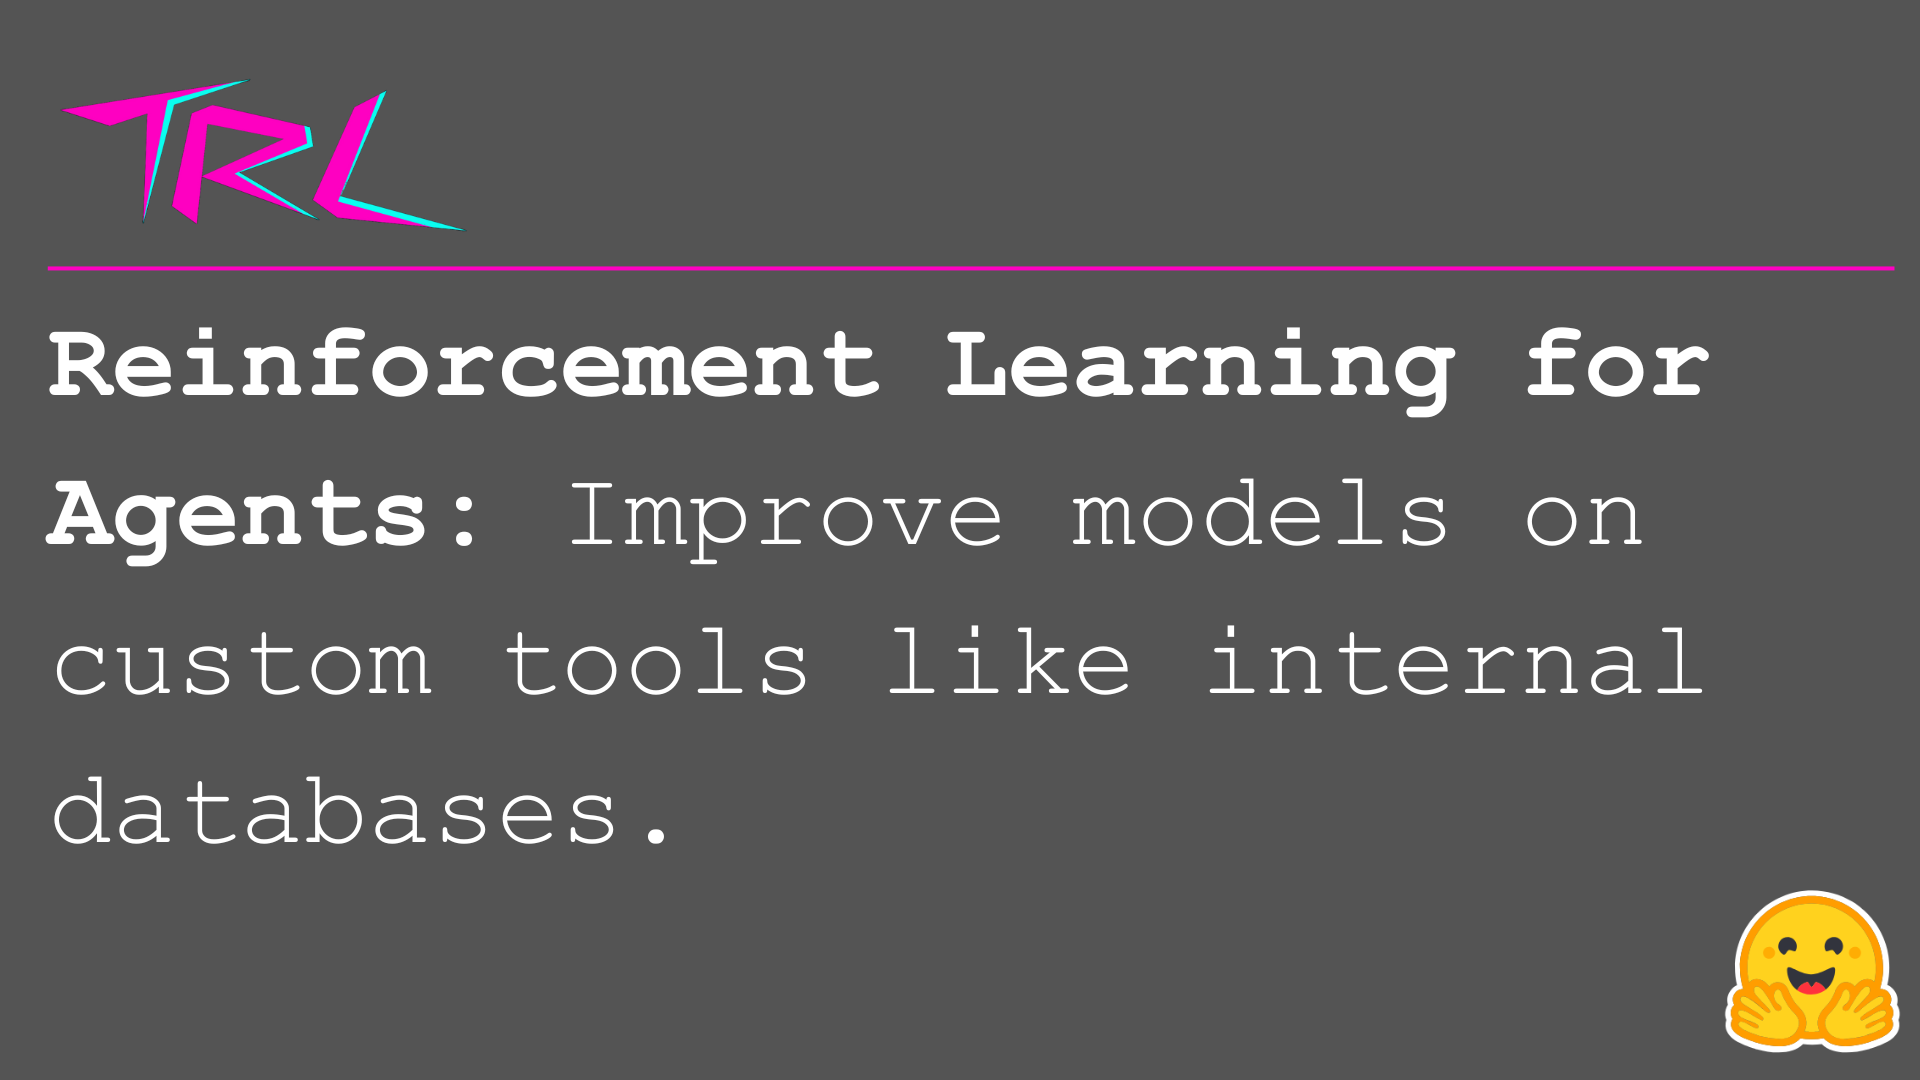

In [1]:
!pip install -qqq jmespath
!pip install -qqq git+https://github.com/huggingface/transformers.git
!pip install -qqq git+https://github.com/huggingface/trl.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.0/521.0 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Tools: Custom Knowledge Base
## Hotel booking agent

In this tutorial we are going to build and train a custom agent for managing hotel bookings. We'll set up a `postgres` database and expose tools to the agent, and then use the GRPO algorithm from TRL to improve the agents performance.


![postrges](https://kinsta.com/wp-content/uploads/2022/02/postgres-logo.png)

Start a postgres server which we'll use as a demo knowledge base.

In [2]:
# Install postgresql to run a DB server on colab
%%shell

sudo apt-get -y -qq update > /dev/null 2>&1
sudo apt-get -y -qq install postgresql > /dev/null 2>&1

In [3]:
# Start the postgresql server.
!sudo service postgresql start

# Check that postgres is running
!sudo lsof -i :5432

 * Starting PostgreSQL 14 database server
   ...done.
COMMAND   PID     USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
postgres 3772 postgres    5u  IPv6  57608      0t0  TCP localhost:postgresql (LISTEN)
postgres 3772 postgres    6u  IPv4  57609      0t0  TCP localhost:postgresql (LISTEN)


We have a postgres server, so let's setup a database.

In [4]:
# Create a dedicated database and a user to access our DB securely
%%shell

sudo -u postgres psql << EOF
CREATE USER hotel_user WITH PASSWORD 'my-password';
CREATE DATABASE hotel_db;
GRANT ALL PRIVILEGES ON DATABASE hotel_db TO hotel_user;
ALTER DATABASE hotel_db OWNER TO hotel_user;
EOF

CREATE ROLE
CREATE DATABASE
GRANT
ALTER DATABASE


Now we're going to populate out database with dummy hotels.

In [5]:
# Connect to the database with the new user and create a hotels table.
%%shell

export PGPASSWORD=my-password
psql -h 127.0.0.1 -U hotel_user -d hotel_db --no-password << EOF
CREATE TABLE hotels(
   id            INTEGER NOT NULL PRIMARY KEY,
   name          VARCHAR NOT NULL,
   location      VARCHAR NOT NULL,
   price_tier    VARCHAR NOT NULL,
   checkin_date  DATE    NOT NULL,
   checkout_date DATE    NOT NULL,
   booked        BIT     NOT NULL
);
INSERT INTO hotels(id, name, location, price_tier, checkin_date, checkout_date, booked)
VALUES
  (1, 'Hilton Basel', 'Basel', 'Luxury', '2024-04-22', '2024-04-20', B'0'),
  (2, 'Marriott Zurich', 'Zurich', 'Upscale', '2024-04-14', '2024-04-21', B'0'),
  (3, 'Hyatt Regency Basel', 'Basel', 'Upper Upscale', '2024-04-02', '2024-04-20', B'0'),
  (4, 'Radisson Blu Lucerne', 'Lucerne', 'Midscale', '2024-04-24', '2024-04-05', B'0'),
  (5, 'Best Western Bern', 'Bern', 'Upper Midscale', '2024-04-23', '2024-04-01', B'0'),
  (6, 'InterContinental Geneva', 'Geneva', 'Luxury', '2024-04-23', '2024-04-28', B'0'),
  (7, 'Sheraton Zurich', 'Zurich', 'Upper Upscale', '2024-04-27', '2024-04-02', B'0'),
  (8, 'Holiday Inn Basel', 'Basel', 'Upper Midscale', '2024-04-24', '2024-04-09', B'0'),
  (9, 'Courtyard Zurich', 'Zurich', 'Upscale', '2024-04-03', '2024-04-13', B'0'),
  (10, 'Comfort Inn Bern', 'Bern', 'Midscale', '2024-04-04', '2024-04-16', B'0');
SELECT * from hotels;
EOF

CREATE TABLE
INSERT 0 10
 id |          name           | location |   price_tier   | checkin_date | checkout_date | booked 
----+-------------------------+----------+----------------+--------------+---------------+--------
  1 | Hilton Basel            | Basel    | Luxury         | 2024-04-22   | 2024-04-20    | 0
  2 | Marriott Zurich         | Zurich   | Upscale        | 2024-04-14   | 2024-04-21    | 0
  3 | Hyatt Regency Basel     | Basel    | Upper Upscale  | 2024-04-02   | 2024-04-20    | 0
  4 | Radisson Blu Lucerne    | Lucerne  | Midscale       | 2024-04-24   | 2024-04-05    | 0
  5 | Best Western Bern       | Bern     | Upper Midscale | 2024-04-23   | 2024-04-01    | 0
  6 | InterContinental Geneva | Geneva   | Luxury         | 2024-04-23   | 2024-04-28    | 0
  7 | Sheraton Zurich         | Zurich   | Upper Upscale  | 2024-04-27   | 2024-04-02    | 0
  8 | Holiday Inn Basel       | Basel    | Upper Midscale | 2024-04-24   | 2024-04-09    | 0
  9 | Courtyard Zurich        | Z

In [6]:
!pip install psycopg2-binary

import psycopg2
from typing import List, Optional

# Database connection parameters
DB_PARAMS = {
    "host": "127.0.0.1",
    "port": "5432",
    "database": "hotel_db",
    "user": "hotel_user",
    "password": "my-password"
}

def get_connection():
    return psycopg2.connect(**DB_PARAMS)

def search_hotels_by_name(name: str) -> List[tuple]:
    """
    Search for hotels based on name.

    Args:
        name: The name of the hotel.

    Returns:
        A list of hotels matching the name.
    """
    conn = get_connection()
    try:
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM hotels WHERE name ILIKE %s", ('%' + name + '%',))
            return cur.fetchall()
    finally:
        conn.close()

def search_hotels_by_location(location: str) -> List[tuple]:
    """
    Search for hotels based on location.

    Args:
        location: The location of the hotel.

    Returns:
        A list of hotels matching the location.
    """
    conn = get_connection()
    try:
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM hotels WHERE location ILIKE %s", ('%' + location + '%',))
            return cur.fetchall()
    finally:
        conn.close()

def book_hotel(hotel_id: str):
    """
    Book a hotel by its ID. If the hotel is successfully booked, returns None.

    Args:
        hotel_id: The ID of the hotel to book.
    """
    conn = get_connection()
    try:
        with conn.cursor() as cur:
            cur.execute("UPDATE hotels SET booked = B'1' WHERE id = %s", (hotel_id,))
        conn.commit()
    finally:
        conn.close()

def update_hotel(hotel_id: str, checkin_date: str, checkout_date: str) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.
    Returns a message indicating whether the hotel was successfully updated or not.

    Args:
        hotel_id: The ID of the hotel to update.
        checkin_date: The new check-in date of the hotel.
        checkout_date: The new check-out date of the hotel.
    """
    conn = get_connection()
    try:
        with conn.cursor() as cur:
            cur.execute(
                "UPDATE hotels SET checkin_date = %s, checkout_date = %s WHERE id = %s",
                (checkin_date, checkout_date, hotel_id)
            )
        conn.commit()
        return "Hotel updated successfully"
    except Exception as e:
        return f"Failed to update hotel: {e}"
    finally:
        conn.close()

def cancel_hotel(hotel_id: str):
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id: The ID of the hotel to cancel.
    """
    conn = get_connection()
    try:
        with conn.cursor() as cur:
            cur.execute("UPDATE hotels SET booked = B'0' WHERE id = %s", (hotel_id,))
        conn.commit()
    finally:
        conn.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.7 MB/s eta 0:00:00


# Dataset

In [7]:
from datasets import Dataset

prompt = """
  You're a helpful hotel assistant. You handle hotel searching, booking and
  cancellations. When the user searches for a hotel, mention it's name, id,
  location and price tier. Always mention hotel ids while performing any
  searches. This is very important for any operations. For any bookings or
  cancellations, please provide the appropriate confirmation. Be sure to
  update checkin or checkout dates if mentioned by the user.
  Don't ask for confirmations from the user.
"""

dataset = Dataset.from_list(
    [
        {
            "prompt": [
                {"role": "system", "content": prompt},
                {"role": "user", "content": "Find hotels in Basel with Basel in it's name."},
            ],
            "answer": "Hilton Basel"
        },
        {
            "prompt": [
                {"role": "system", "content": prompt},
                {"role": "user", "content": "Can you book the Hilton Basel for me?"},
            ],
            "answer": "booked"
        },
        {
            "prompt": [
                {"role": "system", "content": prompt},
                {
                    "role": "user",
                    "content": "Oh wait, this is too expensive. Please cancel it and book the Hyatt Regency instead.",
                },
            ],
            "answer": "Hyatt Regency Basel"
        },
        {
            "prompt": [
                {"role": "system", "content": prompt},
                {
                    "role": "user",
                    "content": "My check in dates would be from April 10, 2024 to April 19, 2024.",
                },
            ],
            "answer": "updated"
        },
    ]
)

# Train

In [8]:
def accuracy(completions, answer, **kwargs):
    predictions = [completion[-1]["content"] for completion in completions]
    rewards = [float(str(ans).lower() in pred.lower()) for pred, ans in zip(predictions, answer)]
    return rewards

In [9]:
from trl import GRPOTrainer, GRPOConfig
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, padding_side="left")
model = AutoModelForCausalLM.from_pretrained(checkpoint, dtype="auto", device_map="auto")

# Load LoRA
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=1,
    lora_alpha=16,
    target_modules="all-linear",
)
model = get_peft_model(model, lora_config)

# Training arguments
training_args = GRPOConfig(
    output_dir="hotel-agent",
    learning_rate=1e-6,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_generations=4,
    num_train_epochs=1,
)

trainer = GRPOTrainer(
    model=model,
    args=training_args,
    processing_class=tokenizer,
    train_dataset=dataset,
    tools=[
        search_hotels_by_location,
        search_hotels_by_name,
        book_hotel,
        update_hotel,
        cancel_hotel,
    ],
    reward_funcs=accuracy,
)
trainer.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.
`generation_config` default values have been modified to match model-specific defaults: {'temperature': 0.6, 'top_p': 0.95}. If this is not desired, please set these values explicitly.


Step,Training Loss


TrainOutput(global_step=1, training_loss=0.0, metrics={'train_runtime': 127.1645, 'train_samples_per_second': 0.031, 'train_steps_per_second': 0.008, 'total_flos': 0.0, 'train_loss': 0.0})

# Generate

In [10]:
import torch

messages = [
  {"role": "system", "content": prompt},
  {"role": "user", "content": "Find a hotel in Lucerne"}
]

tools = tools=[
        search_hotels_by_location,
        search_hotels_by_name,
        book_hotel,
        update_hotel,
        cancel_hotel,
]

inputs = tokenizer.apply_chat_template(messages, tools=tools, add_generation_prompt=True, return_dict=True, return_tensors="pt", enable_thinking=False)
outputs = model.generate(**inputs.to(model.device), max_new_tokens=1028)
print(tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):]))
print(outputs)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<tool_call>이모ED Namelicants Solution * Name Instructionsropriate Question Instructions*Question Description Question Instructions자licants Navigationropriate Namelicants AnswerQuestion Questionlicants Solution ** Answer자해글Question AnswerQuestion AnswerQuestionQuestion Question InstructionsQuestion Name Instructions Question Instructions Solution Instructions InstructionsImplementationropriate Name DescriptionQuestion Navigation NavigationlicantsotionalClass Instructions Answer Question QuestionQuestion자기유 InstructionsComparison Solution Explanation Answer Question Solution Answer**Class Solution * Name Question자기비지모지otionalQuestion Instructions QuestionQuestion InstructionsComparison Description* Question자licantsClassQuestion Questionlicants AnswerQuestionPublication Instructions QuestionComparisonComparisonlicantslicantslicantsropriate Instructions Question Navigation AnswerComparison Instructions Solution Question글자arentarent Answer Answer Instructions Answer AnswerQuestionQuestionQue

In [15]:
print(tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):]))

<tool_call>이모ED Namelicants Solution * Name Instructionsropriate Question Instructions*Question Description Question Instructions자licants Navigationropriate Namelicants AnswerQuestion Questionlicants Solution ** Answer자해글Question AnswerQuestion AnswerQuestionQuestion Question InstructionsQuestion Name Instructions Question Instructions Solution Instructions InstructionsImplementationropriate Name DescriptionQuestion Navigation NavigationlicantsotionalClass Instructions Answer Question QuestionQuestion자기유 InstructionsComparison Solution Explanation Answer Question Solution Answer**Class Solution * Name Question자기비지모지otionalQuestion Instructions QuestionQuestion InstructionsComparison Description* Question자licantsClassQuestion Questionlicants AnswerQuestionPublication Instructions QuestionComparisonComparisonlicantslicantslicantsropriate Instructions Question Navigation AnswerComparison Instructions Solution Question글자arentarent Answer Answer Instructions Answer AnswerQuestionQuestionQue

In [21]:
messages = [
  {"role": "system", "content": "You are a helpful travel agent"},
  {"role": "user", "content": "Where can I stay at a hilton?"}
]
model1 = AutoModelForCausalLM.from_pretrained(checkpoint, dtype="auto", device_map="auto")
inputs = tokenizer.apply_chat_template(messages, tools=tools, add_generation_prompt=True, return_dict=True, return_tensors="pt", enable_thinking=False)
outputs = model1.generate(**inputs.to(model.device), max_new_tokens=1028)

Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


In [22]:
print(tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):]))

I can help you find hotels in your desired location. Could you please specify the location?<|im_end|>


In [23]:
inputs = tokenizer.apply_chat_template(messages, tools=tools, add_generation_prompt=True, return_dict=True, return_tensors="pt", enable_thinking=False)
outputs = model.generate(**inputs.to(model.device), max_new_tokens=1028)
print(tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):]))

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Iotionalarent Instructions InstructionsQuestion Answer글 Instructionslicants Instructions Solution Description Descriptionlicants Question글이글 Name QuestionClass*Question Instructions Instructions InstructionsAddressQuestion Answer글이 Instructions* Question Answer Instructions Answer SolutionExplanation글 Instructions Instructions Description Instructions InstructionslyingComparison Description Question Question*Question Instructions Instructionslicants Answer글 Answer Answer Instructions Question Solution Solution Name AnswerExplanation Instructions Navigation AnswerQuestion Question Navigation Name**Question InstructionsropriatelicantsClasslicants Name Solution Question QuestionClassSolution * Solution* Instructions AnswerQuestion Instructions Navigationarentlications Instructions Description * InstructionsQuestion Instructions자지otional Answer글otional Name QuestionQuestion Question자기otional Name QuestionlicantsQuestion Instructions Solution * Name Question Question Description Answer Solu

In [24]:
print(tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):]))

Iotionalarent Instructions InstructionsQuestion Answer글 Instructionslicants Instructions Solution Description Descriptionlicants Question글이글 Name QuestionClass*Question Instructions Instructions InstructionsAddressQuestion Answer글이 Instructions* Question Answer Instructions Answer SolutionExplanation글 Instructions Instructions Description Instructions InstructionslyingComparison Description Question Question*Question Instructions Instructionslicants Answer글 Answer Answer Instructions Question Solution Solution Name AnswerExplanation Instructions Navigation AnswerQuestion Question Navigation Name**Question InstructionsropriatelicantsClasslicants Name Solution Question QuestionClassSolution * Solution* Instructions AnswerQuestion Instructions Navigationarentlications Instructions Description * InstructionsQuestion Instructions자지otional Answer글otional Name QuestionQuestion Question자기otional Name QuestionlicantsQuestion Instructions Solution * Name Question Question Description Answer Solu